In [1]:
import numpy as np # used for scientific computing
import pandas as pd # used for data analysis and manipulation
import matplotlib.pyplot as plt # used for3 visualization and plotting

In [2]:
dfTweets= pd.read_csv('CleanData_100k_with_prediction.csv')
dfFare= pd.read_csv('Binance_BTCUSDT_1h.csv')

In [3]:
del dfTweets['Unnamed: 0']
del dfTweets['Unnamed: 11']
del dfTweets['Unnamed: 12']
del dfTweets['Unnamed: 13']



detecting NA

In [4]:
naCounter=[(dfTweets[i].isna().sum(), i) for i in dfTweets.columns]
# print(naCounter)

new feature with 1 if location exists and 0 if not

In [5]:
user_loaction_before_preprocess=dfTweets['user_location']
user_loaction_after_preprocess=[1 if type(value)!=float else 0 for value in user_loaction_before_preprocess]
dfTweets['location_new_feature']=user_loaction_after_preprocess

convert features of type time in string to timestamp

In [6]:
from datetime import datetime
from datetime import timezone
def strToTimeStampConvertor(i_timeStr):
    return datetime.strptime(i_timeStr, '%d/%m/%Y %H:%M')

In [7]:
dfTweets.user_created = dfTweets.user_created.apply(strToTimeStampConvertor)
dfTweets.date_new = dfTweets.date_new.apply(strToTimeStampConvertor)

make new feature with seniority (number of days from signup to tweet) - then deivide the goup into three bins of seniority

In [8]:
user_created_date=np.array(dfTweets['user_created'])
user_tweet_date=np.array(dfTweets['date_new'])
dfTweets['seniority']=user_tweet_date-user_created_date
dfTweets=dfTweets.sort_values(by=['seniority'])
first_max_threshold_seniority=np.array(dfTweets.seniority)[len(dfTweets.seniority)//3]
second_max_threshold_seniority=np.array(dfTweets.seniority)[(2*len(dfTweets.seniority))//3]

In [9]:
def mapSeniority(seniorityInDays):
    if(seniorityInDays)<=first_max_threshold_seniority:
        return 0
    if(seniorityInDays)<=second_max_threshold_seniority:
        return 1    
    else :return 2    

In [10]:
dfTweets.seniority=dfTweets.seniority.apply(mapSeniority)

new feature that divides the data by popularity

In [11]:
dfTweets=dfTweets.sort_values(by=['user_followers'])
first_max_threshold=np.array(dfTweets.user_followers)[len(dfTweets.user_followers)//3]
second_max_threshold=np.array(dfTweets.user_followers)[(2*len(dfTweets.user_followers))//3]

In [12]:
def mapPopularity(numFollowers):
    if(numFollowers)<=first_max_threshold:
        return 0
    if(numFollowers)<=second_max_threshold:
        return 1    
    else :return 2    

In [13]:
dfTweets['popularity']=dfTweets.user_followers
dfTweets['popularity']=dfTweets.popularity.apply(mapPopularity)

grouping by source feature

In [14]:
unique,counts=np.unique(np.array(dfTweets['source']),return_counts=True)

In [15]:
# for i in range(len(unique)):
#     print("{} {}".format(unique[i],counts[i]))  

In [16]:
def groupBySource(instanceSource):
    if(instanceSource=='Twitter Web App'):#most popular
        return 2
    if(instanceSource=='Twitter for iPhone'):#second most popular
        return 1
    else :#others
        return 0 
dfTweets["source_group"]=dfTweets.source
dfTweets.source_group=dfTweets.source_group.apply(groupBySource)               

new feature that aggregates the seniority with the verified

In [17]:
aggregationOfSeniorityWithVerified = dfTweets.user_verified
for i,a in enumerate(aggregationOfSeniorityWithVerified):
    if (a and (np.array(dfTweets.seniority)[i]==1 or np.array(dfTweets.seniority)[i]==2)):
        a=1
    else:
        a=0    
dfTweets["aggregationOfSeniorityWithVerified"]=aggregationOfSeniorityWithVerified    

putting the label if the bitcoin value went up or down in the hour following the tweet

In [18]:
dfFare.date=dfFare.date.apply(strToTimeStampConvertor)

In [19]:
from datetime import datetime, timedelta
def hour_rounder(timeStamp):
    return(timeStamp.replace(second=0, minute=0, hour=timeStamp.hour)
               +timedelta(hours=1))
         

In [20]:
def labelTheData(timeStamp):
    roundedUpTimeStamp=hour_rounder(timeStamp)
    return 1 if np.array(dfFare[dfFare.date==roundedUpTimeStamp]['up/down'])[0]=='up' else 0


In [21]:
dfTweets["label"]=dfTweets.date_new
dfTweets["label"]=dfTweets.label.apply(labelTheData)

tweet positive/negative cleaning

In [22]:
dfTweets.pred=dfTweets.pred.apply(lambda x : x.split("'")[1])

In [23]:
def convertPositiveTo1NegativeTo0(sentiment):
    return 1 if sentiment=='positive' else 0

In [24]:
dfTweets['predBinary']=dfTweets.pred.apply(convertPositiveTo1NegativeTo0)

anterior counting

In [25]:
print(len(dfTweets[dfTweets.predBinary==1]))
print(len(dfTweets[dfTweets.predBinary==0]))

20436
5344


In [26]:
dfTweets

,source,user_created,user_location,user_description,user_followers,user_verified,date,date_new,tweet,pred,location_new_feature,seniority,popularity,source_group,aggregationOfSeniorityWithVerified,label,predBinary
25122,Twitter for iPhone,2013-02-13 19:24:00,NaN,Ministro de Hacienda/Finance Minister,100107,True,24/03/2022,2022-03-24 21:23:00,Work 🇸🇻.\n\nVolcano #Bitcoin Bond. https://t.c...,positive,0,2,0,1,True,0,1
18556,Twitter for iPhone,2009-06-10 11:45:00,"Los Angeles, CA",#RokkStar BookMuZicKing@Gmail.com | IG: MuZicK...,100141,True,12/11/2021,2021-11-12 19:08:00,The best #Bitcoin ETF is probably $BITO or $BT...,positive,1,2,0,1,True,1,1
14373,Twitter Web App,2008-09-26 06:54:00,"Atlanta, GA",Launched a couple Call of Duty’s (the Zombies ...,100153,True,20/10/2021,2021-10-20 10:55:00,"@cz_binance Historically, it takes 20, 50, 100...",positive,1,2,0,2,True,0,1
24057,Twitter Web App,2014-04-02 19:34:00,Etats-Unis,BSC Gems Hunter & Promoter 🏆 | DM us for SHILL...,100178,False,16/03/2022,2022-03-16 16:16:00,"Someone transferred $86,720,000 in #Bitcoin an...",positive,1,1,0,2,False,1,1
3120,Twitter Web App,2021-04-06 02:45:00,"California, USA","✨""Everyday is a bank account, and time is our ...",100224,False,19/07/2021,2021-07-19 07:53:00,Some people think Bitcoin is not the future\n\...,positive,1,0,0,2,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,SocialFlow,2007-03-20 17:46:00,Around the world,"Top and breaking news, pictures and videos fro...",23494917,True,22/06/2021,2021-06-22 11:20:00,"#Bitcoin regained some ground, a day after tou...",positive,1,2,2,0,True,0,1
5568,SocialFlow,2007-03-20 17:46:00,Around the world,"Top and breaking news, pictures and videos fro...",23597270,True,23/07/2021,2021-07-23 21:13:00,With typhoon season around the corner for Toky...,positive,1,2,2,0,True,1,1
5435,Twitter Web App,2007-03-20 17:46:00,Around the world,"Top and breaking news, pictures and videos fro...",23597283,True,23/07/2021,2021-07-23 15:34:00,Japanese tennis star Naomi Osaka lights the #O...,positive,1,2,2,2,True,0,1
19902,SocialFlow,2007-03-20 17:46:00,Around the world,"Top and breaking news, pictures and videos fro...",24032114,True,25/11/2021,2021-11-25 14:52:00,El Salvador's President Nayib Bukele took the ...,positive,1,2,2,0,True,1,1


Start Model - Decisioning Tree

In [27]:
from sklearn import tree
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(dfTweets[['user_verified' , 'predBinary' , 'location_new_feature' , 'seniority' , 'popularity' , 'aggregationOfSeniorityWithVerified' , 'label']], random_state=0)
X_train , y_train=np.array(training_data)[:,[0,1,2,3,4,5]] , np.array(training_data)[:,6]
X_test , y_test=np.array(testing_data)[:,[0,1,2,3,4,5]] , np.array(testing_data)[:,6]
y_train=y_train.astype('int32')
y_test=y_test.astype('int32')



In [28]:
clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="random")
clf = clf.fit(X_train , y_train)
predictions=clf.predict(X_test)
matches = np.count_nonzero(predictions == y_test)
print(matches/len(predictions))

0.5281613653995345


In [29]:
#predictions=clf.predict(X_train)
#matches = np.count_nonzero(predictions == y_train)
#print(matches/len(predictions))

[Text(0.4025, 0.9375, 'X[3] <= 0.859\nentropy = 0.998\nsamples = 19335\nvalue = [9148, 10187]'),
 Text(0.18, 0.8125, 'X[2] <= 0.935\nentropy = 0.996\nsamples = 6486\nvalue = [3004, 3482]'),
 Text(0.092, 0.6875, 'X[1] <= 0.602\nentropy = 0.994\nsamples = 3649\nvalue = [1665, 1984]'),
 Text(0.052, 0.5625, 'X[4] <= 1.712\nentropy = 0.989\nsamples = 1392\nvalue = [611, 781]'),
 Text(0.032, 0.4375, 'X[4] <= 0.6\nentropy = 0.989\nsamples = 1378\nvalue = [604, 774]'),
 Text(0.016, 0.3125, 'X[5] <= 0.053\nentropy = 0.987\nsamples = 1263\nvalue = [548, 715]'),
 Text(0.008, 0.1875, 'entropy = 0.987\nsamples = 1262\nvalue = [547, 715]'),
 Text(0.024, 0.1875, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.048, 0.3125, 'X[0] <= 0.142\nentropy = 1.0\nsamples = 115\nvalue = [56, 59]'),
 Text(0.04, 0.1875, 'entropy = 0.999\nsamples = 108\nvalue = [52, 56]'),
 Text(0.056, 0.1875, 'entropy = 0.985\nsamples = 7\nvalue = [4, 3]'),
 Text(0.072, 0.4375, 'X[5] <= 0.638\nentropy = 1.0\nsamples = 14\nv

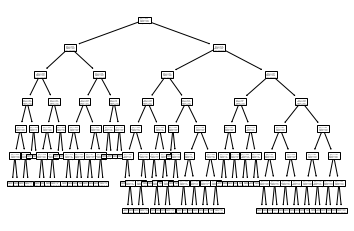

In [30]:
tree.plot_tree(clf)

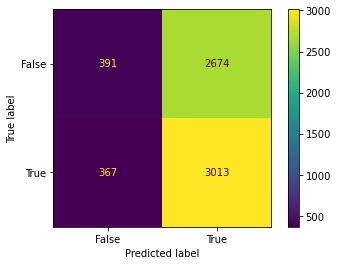

In [31]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Discrete Naive Bayes 

In [32]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
matches = np.count_nonzero(predictions == y_test)
print(matches/len(predictions))

0.5244375484871994
